In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

In [2]:
import pandas as pd
import numpy as np

# 1727, 191
train = pd.read_csv('/Users/bdlab/Desktop/sparse-matrix-multiplication/scenario-extraction/d-optimal/d-optimal-of-spmm/train-test-csv/1727-nonsquare-train-from-1918-nonsquare-spmm-over-3s.csv')
test = pd.read_csv('/Users/bdlab/Desktop/sparse-matrix-multiplication/scenario-extraction/d-optimal/d-optimal-of-spmm/train-test-csv/191-nonsquare-test-from-1918-nonsquare-spmm-over-3s.csv')

In [3]:
# # 원본 feature

# # Train + Valid
# X_train = train[['lr','lc','rc','ld','rd','lnnz','rnnz','lr*lc','lc*rc','lr*rc','lr*lc*rc','ld*rd','lr*rc*ld*rd','lr*lc*rc*ld*rd']] 
# y_train = train['bz_smsm']

# # Test
# X_test = test[['lr','lc','rc','ld','rd','lnnz','rnnz','lr*lc','lc*rc','lr*rc','lr*lc*rc','ld*rd','lr*rc*ld*rd','lr*lc*rc*ld*rd']] 
# y_test = test['bz_smsm']

In [4]:
# 전체 feature -> MAPE 

# Train + Valid
X_train = train[['lr','lc','rc','lnnz','rnnz','lr*lc','lc*rc','lr*rc','lr*lc*rc','lr*rc*ld*rd','lr*lc*rc*ld*rd','lnnz*rnnz']] 
y_train = train['bz_smsm']

# Test
X_test = test[['lr','lc','rc','lnnz','rnnz','lr*lc','lc*rc','lr*rc','lr*lc*rc','lr*rc*ld*rd','lr*lc*rc*ld*rd','lnnz*rnnz']] 
y_test = test['bz_smsm']

In [5]:
# 데이터 표준화(Standardization) (하는게 성능 좋음)
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train -= mean
X_train /= std

X_test -= mean
X_test /= std

In [6]:
# # 특징 추출
# from sklearn.decomposition import PCA

# pca = PCA(n_components=5)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

In [7]:
from keras import backend as K

def rmse(y_true, y_pred):
    rmse = K.sqrt(K.mean(K.square(y_pred - y_true))) 
    return rmse

In [8]:
# 모델 생성
def build_model():

    model=Sequential()

    model.add(Dense(64, activation="relu", input_shape=(X_train.shape[1],)))  
    model.add(Dense(128, activation="relu"))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(1))
    
    optimizer = Adam(lr=0.01)
    
    model.compile(optimizer=optimizer ,
                  loss='mape',
                  metrics=['mape',rmse])
    return model

model = build_model()

In [9]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        #print("epoch : {}, logs : {}".format(epoch,logs))
        print('.', end='')

# monitor는 어떤 매개변수를 볼 것인지 입니다.
# patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다
# 지정된 에포크 횟수 동안 성능 향상이 없으면 자동으로 훈련이 멈춥니다.
early_stop = keras.callbacks.EarlyStopping(monitor='val_mape', patience=150)

EPOCHS = 100000

# 훈련 정확도와 검증 정확도 출력
# 에포크마다 훈련 상태를 점검하기 위해 EarlyStopping 콜백(callback)을 사용합니다.
history = model.fit(X_train, 
                    y_train,
                    epochs=EPOCHS, 
                    validation_split = 0.1, 
                    verbose =0, 
                    callbacks=[early_stop, PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
............................................................

In [10]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mape,rmse,val_loss,val_mape,val_rmse,epoch
655,8.819906,8.819906,9537.083008,19.781033,19.781033,14674.066406,655
656,8.215943,8.215943,9395.673828,21.749813,21.749813,12975.313477,656
657,8.252281,8.252281,9078.068359,23.391788,23.391788,13969.639648,657
658,8.957808,8.957808,9122.938477,24.337484,24.337484,14143.957031,658
659,9.782656,9.782656,11376.370117,21.294382,21.294382,13246.752930,659


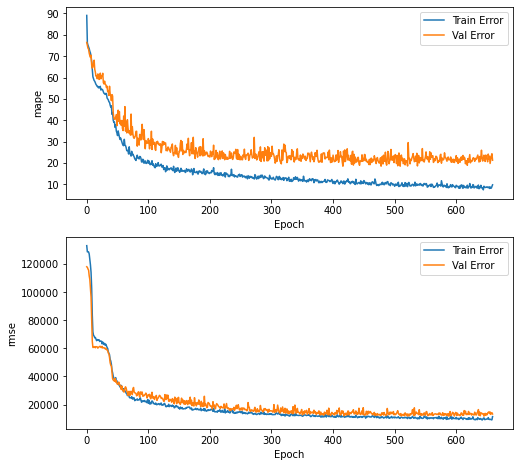

In [11]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    # mape metric
    plt.subplot(3,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('mape')
    plt.plot(hist['epoch'], hist['mape'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mape'],
           label = 'Val Error')
    plt.legend()
    
    # rmse metric
    plt.subplot(3,1,3)
    plt.xlabel('Epoch')
    plt.ylabel('rmse')
    plt.plot(hist['epoch'], hist['rmse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_rmse'],
           label = 'Val Error')
    plt.legend()

    plt.show()
    

plot_history(history)

In [12]:
from sklearn.metrics import mean_squared_error

def mape_error(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

def rmse_error(y_true, y_pred):
    rmse = np.sqrt(np.mean(np.square(y_pred - y_true))) 
    return rmse

In [13]:
# 훈련데이터 예측
y_train_pred = model.predict(X_train).reshape(-1,)
print("-------- 훈련데이터 예측 --------------------------")
print("rmse : {}".format(rmse_error(y_train,y_train_pred)))
print("mape : {}".format(mape_error(y_train,y_train_pred)))
print("\n")

# 테스트데이터 예측
y_pred = model.predict(X_test).reshape(-1,)
print("-------- 테스트데이터 예측 -------------------------")
print("rmse : {}".format(rmse_error(y_test,y_pred)))
print("mape : {}".format(mape_error(y_test,y_pred)))
print("\n")

-------- 훈련데이터 예측 --------------------------
rmse : 11416.218293749625
mape : 10.109844828508383


-------- 테스트데이터 예측 -------------------------
rmse : 10509.639632374536
mape : 21.122853035317082


